In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import pchip_interpolate
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import trapezoid

# from scipy import sparse
from math import atan2, pi, sin, cos, sqrt

## Sovle K

In [3]:
def solver_2x2(params, N_g):
    Delta = 1 / (N_g - 1)
    numTot = int(N_g*(N_g + 1) / 2) # Total number of nodes per kernel

    index_map = np.zeros((N_g, N_g))
    index_map[np.tril_indices(N_g)] = np.arange(1, numTot+1)
    index_map = np.transpose(index_map)

    dummy1 = np.tril(np.reshape(np.arange(1, (N_g**2)+1), (N_g, N_g))).transpose()
    glob_to_mat = dummy1[dummy1 > 0]
    glob_to_mat = np.array(sorted(glob_to_mat))

    indexes = np.kron(np.arange(1, (2*numTot)+1), np.ones(5)).reshape((2*numTot,5)).astype(int)
    indexes = indexes - 1
    weights = np.zeros((2*numTot, 5))
    RHS = np.zeros((2*numTot, 1))

    # Directional derivatives
    s_K_x, s_K_y = np.meshgrid(params.mu, -params.lam)
    s_L_x, s_L_y = np.meshgrid(params.mu, params.mu)

    s_K = np.sqrt(s_K_x**2 + s_K_y**2)
    s_L = np.sqrt(s_L_x**2 + s_L_y**2)

    # K: Iterate over triangular domain
    for indX in range(N_g):
        for indY in range(indX+1):
            glob_ind = int(index_map[indY, indX])
            if (indY == indX): # Boundary
                weights[glob_ind-1, 0] = 1
                RHS[glob_ind-1] = params.f[indY]
            else:
                theta = np.arctan2(s_K_x[indY, indX], -s_K_y[indY, indX])
                if theta > np.pi / 4:
                    # Then it hits the left side
                    sigma = Delta / np.sin(theta)
                    # Vector length
                    d = sigma * np.cos(theta)
                    # Distance from top
                    preFactor = (s_K[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor
                    # Top left
                    weights[glob_ind-1, 1] = -preFactor * d / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY + 1, indX - 1])-1

                    # Bottom left
                    weights[glob_ind-1, 2] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY, indX - 1])-1
                else:
                    # Then it hits the top
                    sigma = Delta / np.cos(theta)
                    # Vector length
                    d = sigma * np.sin(theta)
                    # Distance from top
                    preFactor = (s_K[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor
                    # Top left
                    weights[glob_ind-1, 1] = -preFactor * d / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY + 1, indX - 1])-1
                    # Top right
                    weights[glob_ind-1, 2] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY + 1, indX])-1

                if indY == indX - 1:
                    # Subdiagnoal
                    # Top left node DOES NOT EXIST, so instead distribute to the
                    # neightbours
                    if theta > np.pi / 4: # Then it hits the left side
                        weights[glob_ind-1, 2] = weights[glob_ind-1, 2] + weights[glob_ind-1, 1]
                        weights[glob_ind-1, 0] = weights[glob_ind-1, 0] - weights[glob_ind-1, 1]
                        indexes[glob_ind-1, 1] = int(index_map[indY + 1, indX])-1
                    else: # Then it hits the top side
                        weights[glob_ind-1, 2] = weights[glob_ind-1, 2] + weights[glob_ind-1, 1]
                        weights[glob_ind-1, 0] = weights[glob_ind-1, 0] - weights[glob_ind-1, 1]
                        indexes[glob_ind-1, 1] = int(index_map[indY, indX - 1])-1
    for indX in range(N_g):
        for indY in range(indX + 1):
            # L: Iterate over triangular domain
            glob_ind = int(index_map[indY, indX]) + numTot
            if indY == 0:
                # Boundary
                weights[glob_ind-1, 0] = -1
                weights[glob_ind-1, 1] = params.q
                indexes[glob_ind-1, 1] = glob_ind - numTot - 1
            else:
                theta = np.arctan2(s_L_y[indY, indX], s_L_x[indY, indX])
                if theta < np.pi / 4:
                    # Then it hits the left side
                    sigma = Delta / np.cos(theta)
                    # Vector length
                    d = sigma * np.sin(theta)
                    # Distance from top
                    preFactor = (s_L[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor
                    # Top left
                    weights[glob_ind-1, 1] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY, indX - 1]) + numTot - 1

                    # Bottom left
                    weights[glob_ind-1, 2] = -preFactor * d / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY - 1, indX - 1]) + numTot - 1
                else:
                    # Then it hits the bottom
                    sigma = Delta / np.sin(theta)
                    # Vector length
                    d = sigma * np.cos(theta)
                    # Distance from right
                    preFactor = (s_L[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor

                    # Bottom left
                    weights[glob_ind-1, 1] = -preFactor * d / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY - 1, indX - 1]) + numTot - 1

                    # Bottom right
                    weights[glob_ind-1, 2] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY - 1, indX]) + numTot - 1

            # Source terms
    for indX in range(N_g):
        for indY in range(indX+1):
            glob_ind = int(index_map[indY, indX])
            if indY != indX:
                weights[glob_ind-1, 3] = -params.a_1[indY, indX]
                weights[glob_ind-1, 4] = -params.a_2[indY, indX]
                indexes[glob_ind-1, 4] = glob_ind + numTot - 1

            if indY != 0:
                weights[glob_ind-1+numTot, 3] = -params.b_1[indY, indX]
                indexes[glob_ind-1+numTot, 3] = glob_ind - 1
                weights[glob_ind-1+numTot, 4] = -params.b_2[indY, indX]

    ## Matrix solving
    counter = 0
    A_coord_x = np.zeros(2*numTot * 5, dtype=int)
    A_coord_y = np.zeros(2*numTot * 5, dtype=int)
    A_vals = np.zeros(2*numTot * 5)

    b_coord_y = np.zeros(2*numTot, dtype=int)
    b_vals = np.zeros(2*numTot)

    for i in range(2*numTot):
        for j in range(5):

            A_coord_y[counter] = i
            A_coord_x[counter] = indexes[i, j]
            A_vals[counter] = weights[i, j]
            counter += 1
        b_coord_y[i] = i
        b_vals[i] = RHS[i][0]

    A = csr_matrix((A_vals, (A_coord_y, A_coord_x)), shape=(2*numTot, 2*numTot))
    b = csr_matrix((b_vals, (b_coord_y, np.zeros(2*numTot))), shape=(2*numTot, 1))

    x = spsolve(A, b)

    K = np.zeros((N_g, N_g))
    L = np.zeros((N_g, N_g))

    K_dummy = x[:numTot]
    L_dummy = x[numTot:2*numTot]

    K[np.tril_indices(N_g)] = K_dummy
    L[np.tril_indices(N_g)] = L_dummy
    K = K.transpose()
    L = L.transpose()

    return K, L

## Solve K 2 $\times$ 2

In [4]:

def K_solver_2x2(fun,N_g):
    class Struct:
        pass
    xspan = np.linspace(0, 1, N_g)
    params = Struct()
    params.mu = fun.mu(xspan)
    params.lam = fun.lam(xspan)
    params.a_1 = np.zeros((N_g,N_g))
    params.a_2 = np.zeros((N_g,N_g))
    params.b_1 = np.zeros((N_g,N_g))
    params.b_2 = np.zeros((N_g,N_g))

    for i in range(N_g):
        for j in range(N_g):
            # lambda'(xi)
            params.a_1[i, j] = fun.lam_d(xspan[i])
            # c_2(xi)
            params.a_2[i, j] = fun.c_2(xspan[i])
            # c_1(xi)
            params.b_1[i, j] = fun.c_1(xspan[i])
            # mu'(xi)
            params.b_2[i, j] = - fun.mu(xspan[i])
    # boundary conditions with k(x,x)
    params.f = -fun.c_2(xspan) / (fun.lam(xspan) + fun.mu(xspan))

    # boundary condition with l(x,0)
    params.q = fun.q * fun.lam(0) / fun.mu(0)
    Kvu, Kvv = solver_2x2(params, N_g)
    return Kvu, Kvv

## Cal system parameters and funcions

In [5]:
def cal_syspara(rs):
    class Struct:
        pass

# System configuration
    sys = Struct()
    sys.ctrl_on = 1
    sys.RGB_color1 = [1, 0, 0]
    sys.RGB_color2 = [0, 0, 1]
    sys.RGB_color3 = [0, 1, 0]
    sys.style1 = '--'
    sys.style2 = '-.'
    sys.style3 = '-'

    # Simulation parameters
    # Parameter values
    vm = 40  # m/s 
    rm = 0.16  # veh/m
    tau = 60  # s
    Length = 500  # m 
    Timeall = 200  # second
    Veq = lambda rho: vm * (1 - rho/rm)
    vs = Veq(rs)
    gamma = 1
    qs = rs * vs # per second
    ps = vm/rm * qs/vs

    # Adding to sys
    sys.vs = vs
    sys.rs = rs
    sys.ps = ps
    sys.gamma = gamma
    sys.L = Length
    sys.tau = tau
    sys.qs = qs
    
    # System parameters
    fun = Struct()
    fun.lam = lambda x: 1*x + vs - x
    fun.mu = lambda x: 1*x + gamma*ps - vs - x
    fun.lam_d = lambda x: 1*x - x
    fun.mu_d = lambda x: 1*x - x
    fun.c_1 = lambda x: 1*x - x
    fun.c_2 = lambda x: -1/tau * np.exp(-x/(tau*vs))
    fun.q = (vs - gamma*ps)/vs
    sys.fun = fun
    sys.N = 100
    sys.N_grid = sys.N + 2
    sys.N_g = 100
    sys.simH = Timeall
    sys.h = 0.1
    sys.Tspan = np.arange(0, sys.simH+sys.h, sys.h)
    sys.Delta = sys.L / (sys.N + 1)
    sys.xspan = np.linspace(0, sys.L, sys.N_grid)
    sys.xspanT = np.arange(sys.Delta, sys.L - sys.Delta + sys.h, sys.Delta)
    sys.intArr = sys.Delta * np.hstack((0.5, np.ones(sys.N), 0.5))
    sys.lam = fun.lam(sys.xspan)
    sys.mu = fun.mu(sys.xspan)
    sys.c_1 = fun.c_1(sys.xspan)
    sys.c_2 = fun.c_2(sys.xspan)
    sys.q = fun.q
    sys.gamma_U = 1
    return sys

In [6]:
sys1 = cal_syspara(0.09)
sys2 = cal_syspara(0.118)
sys4 = cal_syspara(0.122)
sys5 = cal_syspara(0.15)

In [7]:
def zeroToNan(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j < i:
                x[i][j] = float('nan')
    return x

## System setting and calculation

In [8]:
class Struct:
    pass

# System configuration
sys = Struct()
sys.ctrl_on = 1
sys.RGB_color1 = [1, 0, 0]
sys.RGB_color2 = [0, 0, 1]
sys.RGB_color3 = [0, 1, 0]
sys.style1 = '--'
sys.style2 = '-.'
sys.style3 = '-'

# Simulation parameters
# Parameter values
vm = 40  # m/s 
rm = 0.16  # 240 veh/m
tau = 60  # s
L = 500  # m 
Timeall = 200  # second 
rs = 0.12 # veh/m
Veq = lambda rho: vm * (1 - rho/rm)
vs = Veq(rs)
gamma = 1
qs = rs * vs # 
ps = vm/rm * qs/vs

# Adding to sys
sys.vs = vs
sys.rs = rs
sys.ps = ps
sys.gamma = gamma
sys.L = L
sys.tau = tau
sys.qs = qs

# System parameters
fun = Struct()
fun.lam = lambda x: 1*x + vs - x
fun.mu = lambda x: 1*x + gamma*ps - vs - x
fun.lam_d = lambda x: 1*x - x
fun.mu_d = lambda x: 1*x - x
fun.c_1 = lambda x: 1*x - x
fun.c_2 = lambda x: -1/tau * np.exp(-x/(tau*vs))
fun.q = (vs - gamma*ps)/vs
sys.fun = fun
sys.N = 100
sys.N_grid = sys.N + 2
sys.N_g = 100
sys.simH = Timeall
sys.h = 0.1
sys.Tspan = np.arange(0, sys.simH+sys.h, sys.h)
sys.Delta = sys.L / (sys.N + 1)
sys.xspan = np.linspace(0, sys.L, sys.N_grid)
sys.xspanT = np.arange(sys.Delta, sys.L - sys.Delta + sys.h, sys.Delta)
sys.intArr = sys.Delta * np.hstack((0.5, np.ones(sys.N), 0.5))
sys.lam = fun.lam(sys.xspan)
sys.mu = fun.mu(sys.xspan)
sys.c_1 = fun.c_1(sys.xspan)
sys.c_2 = fun.c_2(sys.xspan)
sys.q = fun.q
sys.t_1 = np.dot(sys.intArr, 1/sys.lam)
sys.t_2 = np.dot(sys.intArr, 1/sys.mu)
sys.t_F = sys.t_1 + sys.t_2
sys.gamma_U = 1

## Training settings

In [9]:
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 20
learning_rate = 0.001
step_size= 100
gamma4learning = 0.1


X = sys.L
dx = sys.Delta
nx = sys.N_grid
grids = []
grid = np.linspace(0, sys.L, sys.N_grid, dtype=np.float32).reshape(sys.N_grid,1)
grid = torch.from_numpy(grid).cuda()

In [10]:
meshy, meshx = np.meshgrid(sys.xspan, sys.xspan)

In [11]:
ndata = 1000
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)

In [12]:
y = y.reshape(y.shape[0], y.shape[1])
x = x.reshape(x.shape[0], x.shape[1])
x = np.array(x, dtype=np.float32).reshape(ndata, len(x[0]))
y = np.array(y, dtype=np.float32).reshape(ndata, sys.N*(sys.N+1))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False, generator=torch.Generator(device = 'cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device = 'cuda'))


## Calculate model parameters

In [14]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

## Define model

In [15]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 1
m = 105
branch = [m, 256, 256]
trunk = [dim_x, 128, 256]
activation = "relu"
kernel = "Glorot normal"

class DeepONetModified(nn.Module):
    def __init__(self, branch, trunk, activation, kernel, projection):
        super(DeepONetModified, self).__init__()
        self.net1 = dde.nn.DeepONetCartesianProd(branch, trunk, activation, kernel)
        self.fc1 = nn.Linear(102, 200)
        self.fc2 = nn.Linear(200, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, projection)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x, grid = x[0], x[1]
        x = self.net1((x, grid))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
       
projection  = 10100
model = DeepONetModified(branch, trunk, activation, kernel, projection)
print(count_params(model))

11207661


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma4learning)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
#                                                     # milestones = [100,150,200,300,1000,1050,1100, 1200],
#                                                     # milestones = [100,150,200],
#                                                     milestones = [100,400,800, 1500],
#                                                     gamma = 0.2)
loss = torch.nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []
learning_rate

0.001

## Training

In [18]:
train_flag = 1

In [19]:
if train_flag == 1:
    
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_loss = 0
        for x, y in trainData:
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            out = model((x, grid))
            
            lp = loss(out, y)
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in testData:
                x, y = x.cuda(), y.cuda()
                
                out = model((x, grid))
                test_loss += loss(out, y).item()
                
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = default_timer()
        time_Arr.append(t2-t1)
        if ep%50 == 0:
            print(ep, t2-t1, train_loss, test_loss)
    np.savetxt('train_lossArr.dat', train_lossArr)
    np.savetxt('test_lossArr.dat', test_lossArr)

else:
    model.load_state_dict(torch.load('paraToKTorchModel2'))

0 0.37685363100001723 0.7868374453165516 0.00032561025000177324
50 0.08743912300008105 3.3925957845484493e-09 3.328100639521381e-09
100 0.08942653799999789 3.3920000043331636e-09 3.323145048028664e-09
150 0.091388160000065 3.391987199760946e-09 3.327694519938973e-09
200 0.088013751999938 3.391826454269954e-09 3.323551389655677e-09
250 0.08736420000002454 3.391767622318298e-09 3.3282200551099094e-09
300 0.10364738700002363 3.3912686634194086e-09 3.3252545605932936e-09
350 0.08993822200000068 3.3911931781223834e-09 3.3295710188951945e-09
400 0.08914767300007043 3.3907655350162714e-09 3.329097975068862e-09
450 0.10244678100002602 3.3907564755963903e-09 3.330504361187536e-09


Avg Epoch Time: 0.09530987014200104
Final Testing Loss: 1.665273141604473e-08
Final Training Loss: 1.525801609503219e-07


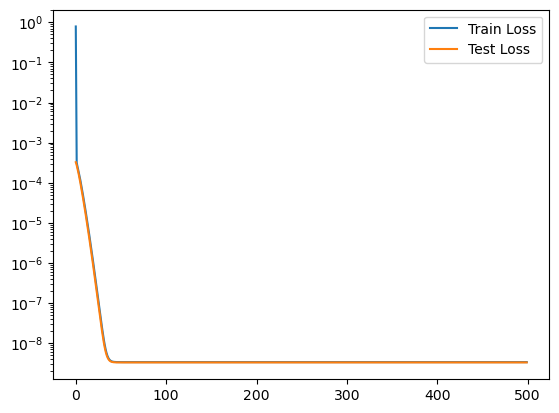

In [20]:
if train_flag == 1:
    # Display Model Details
    plt.figure()
    plt.plot(train_lossArr, label="Train Loss")
    plt.plot(test_lossArr, label="Test Loss")
    plt.yscale("log")
    plt.legend()
    plt.savefig('Train_plot_para2k.pdf',dpi=300)

    testLoss = 0
    trainLoss = 0
    with torch.no_grad():
        for x, y in trainData:
            x, y = x.cuda(), y.cuda()

            out = model((x, grid))
            out = out.reshape((out.shape[0], out.shape[1]))
            trainLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
        for x, y in testData:
            x, y = x.cuda(), y.cuda()

            out = model((x, grid))
            out = out.reshape((out.shape[0], out.shape[1]))
            testLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
        
        
    print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
    print("Final Testing Loss:", testLoss)
    print("Final Training Loss:", trainLoss)

## Prediction

In [22]:
para = np.hstack((sys.lam[0], sys.mu[0], sys.q, sys.c_2))
xdata = np.array(para, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, m))).cuda()
ydata = model((xdata, grid))

In [23]:
ydata_test = ydata.reshape(2, -1)
Kvu1_model = np.zeros((sys.N,sys.N))
Kvv1_model = np.zeros((sys.N,sys.N))
Kvu1_model[np.triu_indices_from(Kvu1_model)] = ydata_test[0,:].cpu().detach().numpy()
Kvv1_model[np.triu_indices_from(Kvv1_model)] = ydata_test[1,:].cpu().detach().numpy()

# sys.Kvu1 = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu[:, -1], sys.xspan)
# sys.Kvv1 = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv[:, -1], sys.xspan)

sys.Kvu1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu1_model[:, -1], sys.xspan)
sys.Kvv1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv1_model[:, -1], sys.xspan)
sys1.Kvu1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu1_model[:, -1], sys.xspan)
sys1.Kvv1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv1_model[:, -1], sys.xspan)
sys2.Kvu1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu1_model[:, -1], sys.xspan)
sys2.Kvv1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv1_model[:, -1], sys.xspan)
sys4.Kvu1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu1_model[:, -1], sys.xspan)
sys4.Kvv1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv1_model[:, -1], sys.xspan)
sys5.Kvu1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu1_model[:, -1], sys.xspan)
sys5.Kvv1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv1_model[:, -1], sys.xspan)


## Markov process

In [24]:
simTseq = np.load('/home/curry/Documents/NOMeanSquare/data/simTseq.npy')
Tseq = np.load('/home/curry/Documents/NOMeanSquare/data/Tseq.npy')
pStates = np.load('/home/curry/Documents/NOMeanSquare/data/pStates.npy')

In [25]:
def ode_dynamic_model(x, t, sys):
    N = sys.N
    N_grid = sys.N_grid
    lam = sys.lam
    mu = sys.mu
    c_1 = sys.c_1
    c_2 = sys.c_2

    dummy = np.reshape(x[0:2*N], (N, 2), order='F')
    dummy_a = np.vstack([2*dummy[0, :] - dummy[1, :], dummy, 2*dummy[N-1, :] - dummy[N-2, :]])

    u_sf_a = dummy_a[:, 0]
    u_sf = u_sf_a[1:sys.N+1]
    v_sf_a = dummy_a[:,1]
    v_sf = v_sf_a[1:sys.N+1]
    U_sf_f = x[2*sys.N]

    if sys.ctrl_on == 1:
        U_sf = trapezoid(sys.Kvu1_model*u_sf_a, sys.xspan, axis=-1) + trapezoid(sys.Kvv1_model*v_sf_a, sys.xspan, axis=-1) - np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]
    else:
        U_sf = 0
    u_sf_a[0] = sys.q * v_sf_a[0]
    v_sf_a[sys.N_grid - 1] = U_sf + np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]

    u_sf_x = np.hstack([(u_sf_a[1] - u_sf_a[0]) / sys.Delta,
                        (u_sf_a[0:(N_grid - 3)] - 4 * u_sf_a[1:(N_grid - 2)] + 3 * u_sf_a[2:(N_grid - 1)]) / (
                                    2 * sys.Delta)])
    v_sf_x = np.hstack(
        [(-3 * v_sf_a[1:(N_grid - 2)] + 4 * v_sf_a[2:(N_grid - 1)] - v_sf_a[3:N_grid]) / (2 * sys.Delta),
         (v_sf_a[N_grid - 1] - v_sf_a[N_grid - 2]) / sys.Delta])

    u_sf_t = -lam[1:(N + 1)] * u_sf_x + c_1[1:(N + 1)] * v_sf
    v_sf_t = mu[1:(N + 1)] * v_sf_x + c_2[1:(N + 1)] * u_sf

    U_sf_f_t = sys.gamma_U * (U_sf - U_sf_f)

    dt = np.hstack([u_sf_t, v_sf_t, U_sf_f_t])

    return dt

## Initial conditions

In [26]:
u_sf_0 = np.exp(sys.xspanT/(sys.tau*sys.vs))*(0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.qs - sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*(-0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs))
v_sf_0 = -0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs*sys.qs/(sys.gamma*sys.ps)
U_sf_f_0 = 0
x0 = np.hstack((u_sf_0, v_sf_0, U_sf_f_0))
# Solve the ODE system
t_log = sys.Tspan

In [27]:
# plt.plot(u_sf_0)
# plt.plot(v_sf_0)

In [28]:
x_log_all= np.zeros((len(t_log), len(x0)))
x_log_all[0, :] = x0
for i in range(1, len(t_log)):
    if simTseq[i] == 0.09:
        x_log, info = odeint(ode_dynamic_model, x0, [t_log[i-1], t_log[i]], args=(sys1,),full_output=True)
        
    elif simTseq[i] == 0.118:
        x_log, info = odeint(ode_dynamic_model, x0, [t_log[i-1], t_log[i]], args=(sys2,),full_output=True)
        
    elif simTseq[i] == 0.122:
        x_log, info = odeint(ode_dynamic_model, x0, [t_log[i-1], t_log[i]], args=(sys4,),full_output=True)
        
    elif simTseq[i] == 0.15:
        x_log, info = odeint(ode_dynamic_model, x0, [t_log[i-1], t_log[i]], args=(sys5,),full_output=True)
        
    else:
        x_log, info = odeint(ode_dynamic_model, x0, [t_log[i-1], t_log[i]], args=(sys,),full_output=True)
        
            
    x_log_all[i, :] = x_log[-1,:]
    x0 = x_log[-1,:]


In [29]:
def solve_PDE(t_log, sys, x_log):
    numT = len(t_log)
    xx = np.reshape(x_log[:, 0:2*sys.N], (numT, 2*sys.N))
    u_sf = xx[:, 0:sys.N]
    v_sf = xx[:, sys.N:2*sys.N]
    u_sf_a = np.zeros((numT, sys.N + 2))
    v_sf_a = np.zeros((numT, sys.N + 2))
    u_sf_a[:, 0] = 2*u_sf[:, 0] - u_sf[:, 1]
    u_sf_a[:, -1] = 2*u_sf[:, -1] - u_sf[:, -2]
    u_sf_a[:, 1:sys.N+1] = u_sf

    v_sf_a[:, 0] = 2*v_sf[:, 0] - v_sf[:, 1]
    v_sf_a[:, -1] = 2*v_sf[:, -1] - v_sf[:, -2]
    v_sf_a[:, 1:sys.N+1] = v_sf
    
    v_sr_ori = v_sf * sys.gamma*sys.ps/sys.qs
    u_sf_mid = u_sf * np.exp(-sys.xspanT.transpose()/(sys.tau*sys.vs))
    u_sf_ori = u_sf_mid + sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*v_sr_ori

    q = u_sf_ori + sys.qs
    v = v_sr_ori + sys.vs
    rho = q/v

    v = v*3.6 
    rho = rho*1000
    U_sf = x_log[:, 2*sys.N]
    uv_sf_norm = np.sqrt(trapezoid(u_sf_a*u_sf_a, sys.xspan, axis=-1) + trapezoid(v_sf_a*v_sf_a, sys.xspan, axis=-1))
    return rho, v, U_sf, uv_sf_norm

In [30]:
rho, v, U_sf, uv_sf_norm = solve_PDE(t_log,sys,x_log_all)

### Plot Density and Velocity

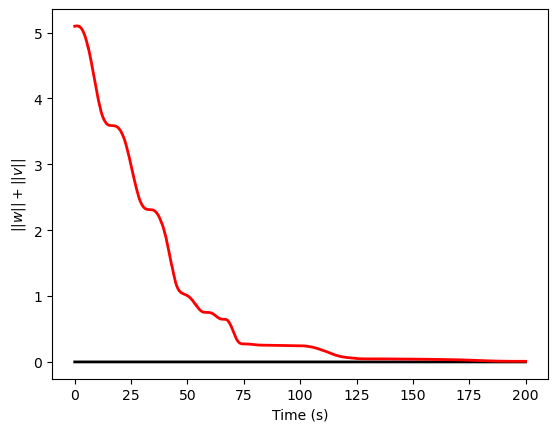

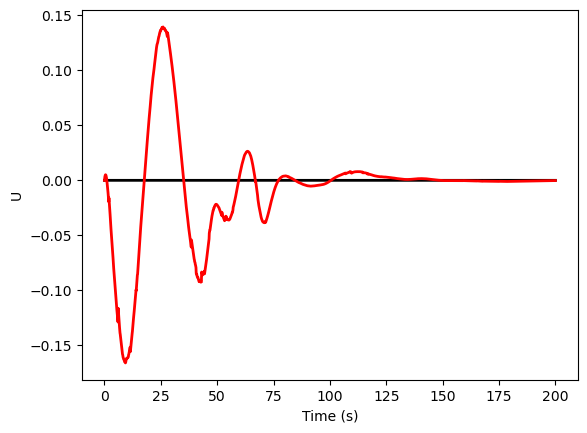

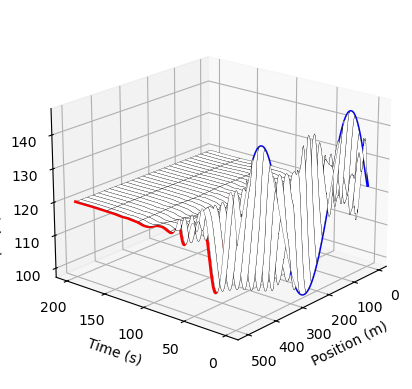

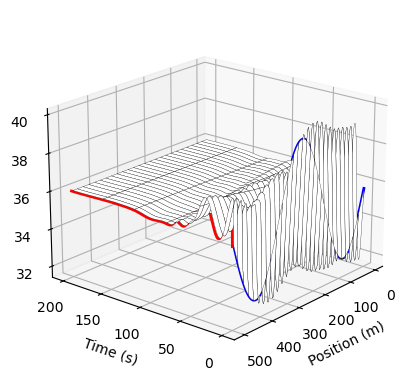

In [31]:
name = 'para2K'
# Norm
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, uv_sf_norm, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.plot(t_log, uv_sf_norm_test, sys.style3, color=sys.RGB_color2, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel(r'$||w||+||v||$')
# plt.savefig('image/'+name+'_w_v.pdf', dpi = 300)
plt.show()
# fig.savefig('uv_sf_norm_no',format='png')

# Actuation
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.savefig('image/'+name+'_U.pdf', dpi = 300)
plt.xlabel('Time (s)')
plt.ylabel('U')
plt.show()
# fig.savefig('U_sf_no',format='png')
# np.save('../image/'+name+'_w_v_U_data.py', [uv_sf_norm, U_sf])

# Density evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, rho, cmap='turbo')
ax.plot_surface(X_arr, T_arr, rho, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), rho[0, :], color='blue', linewidth=2)
ax.plot([sys.L]*len(t_log), t_log, rho[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Density (veh/km)')
ax.view_init(elev=20, azim=-140)
ax.invert_xaxis()
# plt.savefig('image/'+name+'_Density.pdf', dpi = 300)
plt.show()
# fig.savefig('density_no',format='png')

# Velocity evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, v, cmap='turbo')
ax.plot_surface(X_arr, T_arr, v, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), v[0, :], color='blue', linewidth=2)
ax.plot([sys.L]*len(t_log), t_log, v[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Velocity (km/h)')
ax.invert_xaxis()
ax.view_init(elev=20, azim=-140)
# plt.savefig('image/'+name+'_Velocity.pdf', dpi = 300)
plt.show()

In [32]:
np.save("data/uv_sf_norm_para2K", uv_sf_norm)
np.save("data/U_sf_para2K", U_sf)
np.save("data/v_para2K", v)
np.save("data/rho_para2K", rho)
np.save("data/Kvu_no",Kvu1_model)
np.save("data/Kvv_no",Kvv1_model)

In [33]:
rho_sto = np.load('/home/curry/Documents/NOMeanSquare/data/rho_sto.npy')
v_sto = np.load('/home/curry/Documents/NOMeanSquare/data/v_sto.npy')
U_sf_sto = np.load('/home/curry/Documents/NOMeanSquare/data/U_sf_sto.npy')
uv_sf_norm_sto = np.load('/home/curry/Documents/NOMeanSquare/data/uv_sf_norm_sto.npy')

rho_err = rho - rho_sto
v_err = v - v_sto
U_sf_err = U_sf - U_sf_sto
uv_sf_norm_err = uv_sf_norm - uv_sf_norm_sto


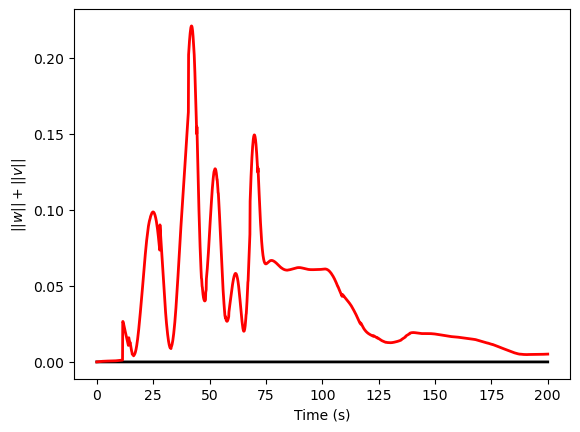

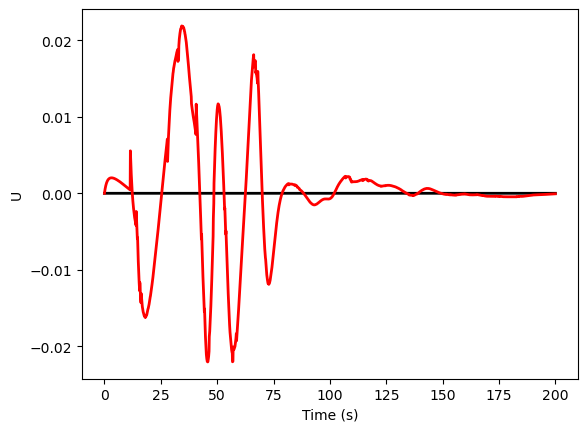

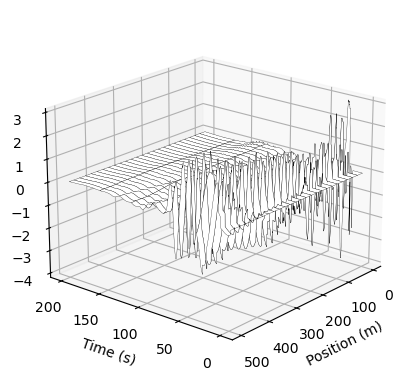

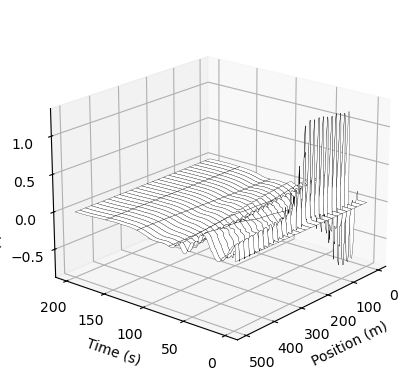

In [34]:
name = 'para2K'
# Norm
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, uv_sf_norm_err, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.plot(t_log, uv_sf_norm_test, sys.style3, color=sys.RGB_color2, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel(r'$||w||+||v||$')
# plt.savefig('image/'+name+'_w_v.pdf', dpi = 300)
plt.show()
# fig.savefig('uv_sf_norm_no',format='png')

# Actuation
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf_err, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.savefig('image/'+name+'_U.pdf', dpi = 300)
plt.xlabel('Time (s)')
plt.ylabel('U')
plt.show()
# fig.savefig('U_sf_no',format='png')
# np.save('../image/'+name+'_w_v_U_data.py', [uv_sf_norm, U_sf])

# Density evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, rho, cmap='turbo')
ax.plot_surface(X_arr, T_arr, rho_err, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
# ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), rho[0, :], color='blue', linewidth=2)
# ax.plot([sys.L]*len(t_log), t_log, rho[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Density (veh/km)')
ax.view_init(elev=20, azim=-140)
ax.invert_xaxis()
# plt.savefig('image/'+name+'_Density.pdf', dpi = 300)
plt.show()
# fig.savefig('density_no',format='png')

# Velocity evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, v, cmap='turbo')
ax.plot_surface(X_arr, T_arr, v_err, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
# ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), v[0, :], color='blue', linewidth=2)
# ax.plot([sys.L]*len(t_log), t_log, v[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Velocity (km/h)')
ax.invert_xaxis()

ax.view_init(elev=20, azim=-140)
# plt.savefig('image/'+name+'_Velocity.pdf', dpi = 300)
plt.show()

In [35]:
rho_num = np.load('/home/curry/Documents/NOMeanSquare/data/rho_num.npy')
v_num = np.load('/home/curry/Documents/NOMeanSquare/data/v_num.npy')
U_sf_num = np.load('/home/curry/Documents/NOMeanSquare/data/U_sf_num.npy')
uv_sf_norm_num = np.load('/home/curry/Documents/NOMeanSquare/data/uv_sf_norm_num.npy')

rho_err = rho - rho_num
v_err = v - v_num
U_sf_err = U_sf - U_sf_num
uv_sf_norm_err = uv_sf_norm - uv_sf_norm_num


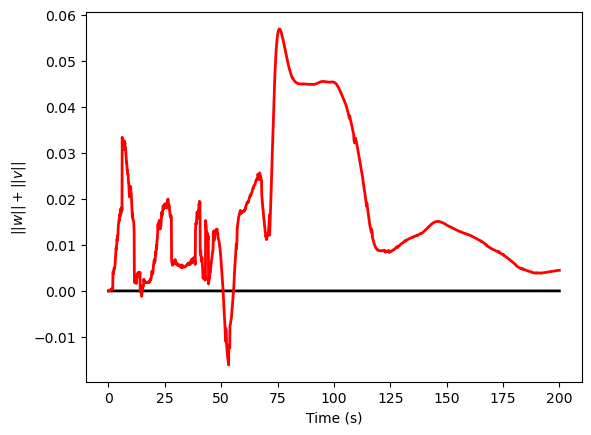

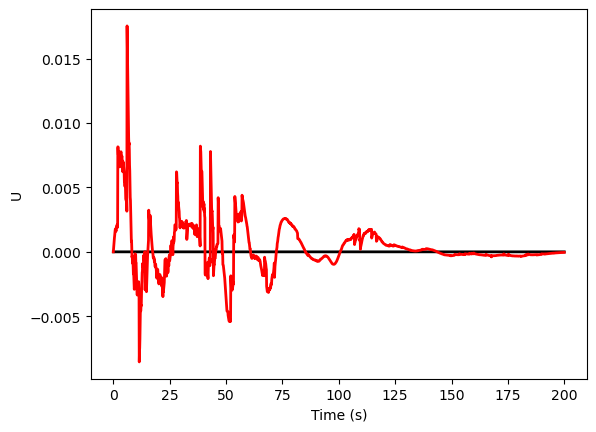

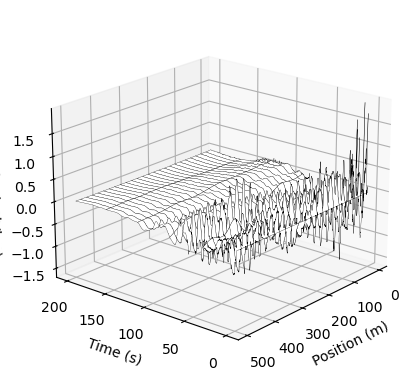

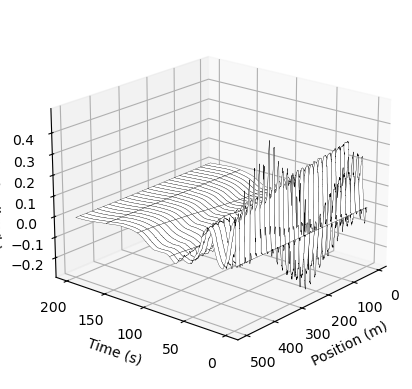

In [36]:
name = 'para2K'
# Norm
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, uv_sf_norm_err, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.plot(t_log, uv_sf_norm_test, sys.style3, color=sys.RGB_color2, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel(r'$||w||+||v||$')
# plt.savefig('image/'+name+'_w_v.pdf', dpi = 300)
plt.show()
# fig.savefig('uv_sf_norm_no',format='png')

# Actuation
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf_err, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.savefig('image/'+name+'_U.pdf', dpi = 300)
plt.xlabel('Time (s)')
plt.ylabel('U')
plt.show()
# fig.savefig('U_sf_no',format='png')
# np.save('../image/'+name+'_w_v_U_data.py', [uv_sf_norm, U_sf])

# Density evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, rho, cmap='turbo')
ax.plot_surface(X_arr, T_arr, rho_err, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
# ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), rho[0, :], color='blue', linewidth=2)
# ax.plot([sys.L]*len(t_log), t_log, rho[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Density (veh/km)')
ax.view_init(elev=20, azim=-140)
ax.invert_xaxis()
# plt.savefig('image/'+name+'_Density.pdf', dpi = 300)
plt.show()
# fig.savefig('density_no',format='png')

# Velocity evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, v, cmap='turbo')
ax.plot_surface(X_arr, T_arr, v_err, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
# ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), v[0, :], color='blue', linewidth=2)
# ax.plot([sys.L]*len(t_log), t_log, v[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Velocity (km/h)')
ax.invert_xaxis()

ax.view_init(elev=20, azim=-140)
# plt.savefig('image/'+name+'_Velocity.pdf', dpi = 300)
plt.show()

### Compute computation time

In [46]:
time_all_num = []
for i in range(100):
    t1 =  default_timer()
    Kvu, Kvv = K_solver_2x2(fun, sys.N_g)
    t2 =  default_timer()
    time_all_num.append(t2-t1)
print("Numerical solve time: {:.4e}".format(sum(time_all_num)/len(time_all_num)))

xdata = np.array(para, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, m))).cuda()
time_all = []
for i in range(100):
    t1 =  default_timer()
    ydata = model((xdata, grid))
    t2 =  default_timer()
    time_all.append(t2-t1)
    
    # print(t2-t1)

print("Avg Time: {:.4e}".format(sum(time_all)/len(time_all)))

Numerical solve time: 5.9007e-02
Avg Time: 1.6844e-04


In [38]:
5.9899e-02/1.7107e-04

350.1432162272754

In [47]:
5.9007e-02/1.6844e-04

350.31465210163856

## Save trained model

In [45]:
# save the trained model by the time now
# model3 is equal to 2024101810_58
from datetime import datetime
format_time = datetime.now().strftime("%Y%m%d_%H%M")
print(format_time)
torch.save(model.state_dict(), "paraToKTorchModel_"+format_time)

20241018_1058
